In [1]:
%%capture output
!pip install brian2
!pip install -q condacolab
import condacolab
condacolab.install()
!conda create -y -n opensim_env python=3.10
!source /usr/local/etc/profile.d/conda.sh && conda activate opensim_env && conda install -y -c opensim-org opensim
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/activation.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/muscle_sim.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/neural_simulations.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/plot_time_series.py



In [1]:
%%capture output
!unzip Model.zip

In [2]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import numpy as np
import pandas as pd
import os
import subprocess
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

from plot_time_series import plot_times_series, load_sto_file
from neural_simulations import run_neural_simulations
from activation import decode_spikes_to_activation


spikes_Ia []
[info] Updating Model file from 40500 to latest format...
[info] Loaded model 3DGaitModel2392 from file Model/gait2392_millard2012_pelvislocked.osim
Simulation complete. Data saved to muscle_output.sto.


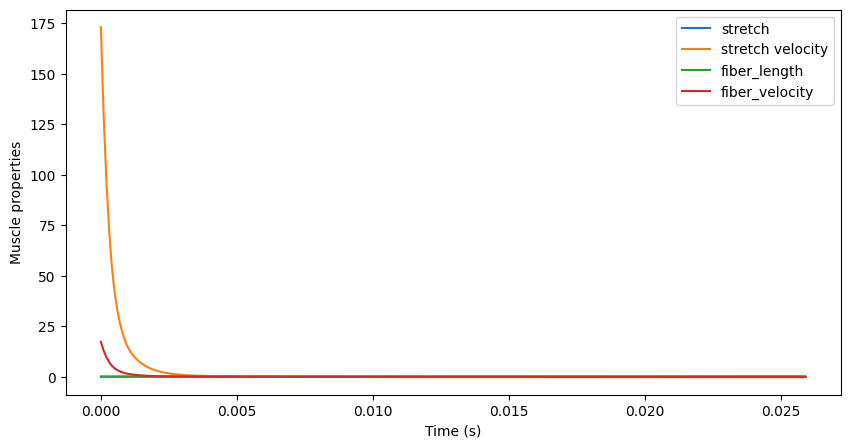

spike_matrix (260, 10)
rows []
cols []
spike_matrix (260, 10)
rows [10]
cols [0]
spike_matrix (260, 10)
rows [ 13  29  33  38  45  48 104 113 123 129 135 141 146 150 154 157 161 182
 187 200 234 239 244 246 252 259]
cols [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


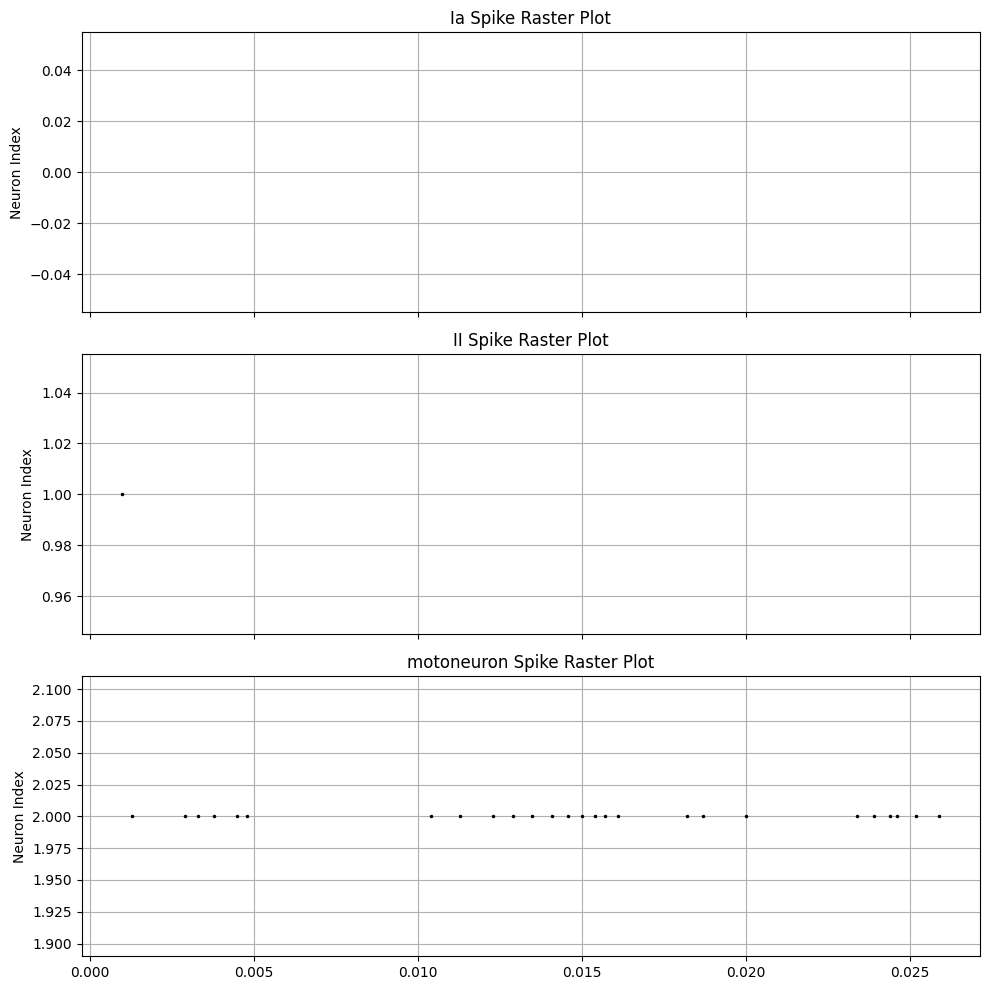

data columns Index(['spikes_times_II_0', 'spikes_times_II_1', 'spikes_times_II_2',
       'spikes_times_II_3', 'spikes_times_II_4', 'spikes_times_II_5',
       'spikes_times_II_6', 'spikes_times_II_7', 'spikes_times_II_8',
       'spikes_times_II_9', 'spikes_times_Ia_0', 'spikes_times_Ia_1',
       'spikes_times_Ia_2', 'spikes_times_Ia_3', 'spikes_times_Ia_4',
       'spikes_times_Ia_5', 'spikes_times_Ia_6', 'spikes_times_Ia_7',
       'spikes_times_Ia_8', 'spikes_times_Ia_9', 'spikes_times_motoneuron_0',
       'spikes_times_motoneuron_1', 'spikes_times_motoneuron_2',
       'spikes_times_motoneuron_3', 'spikes_times_motoneuron_4',
       'spikes_times_motoneuron_5', 'spikes_times_motoneuron_6',
       'spikes_times_motoneuron_7', 'spikes_times_motoneuron_8',
       'spikes_times_motoneuron_9', 'activation_0', 'activation_1',
       'activation_2', 'activation_3', 'activation_4', 'activation_5',
       'activation_6', 'activation_7', 'activation_8', 'activation_9',
       'activation_

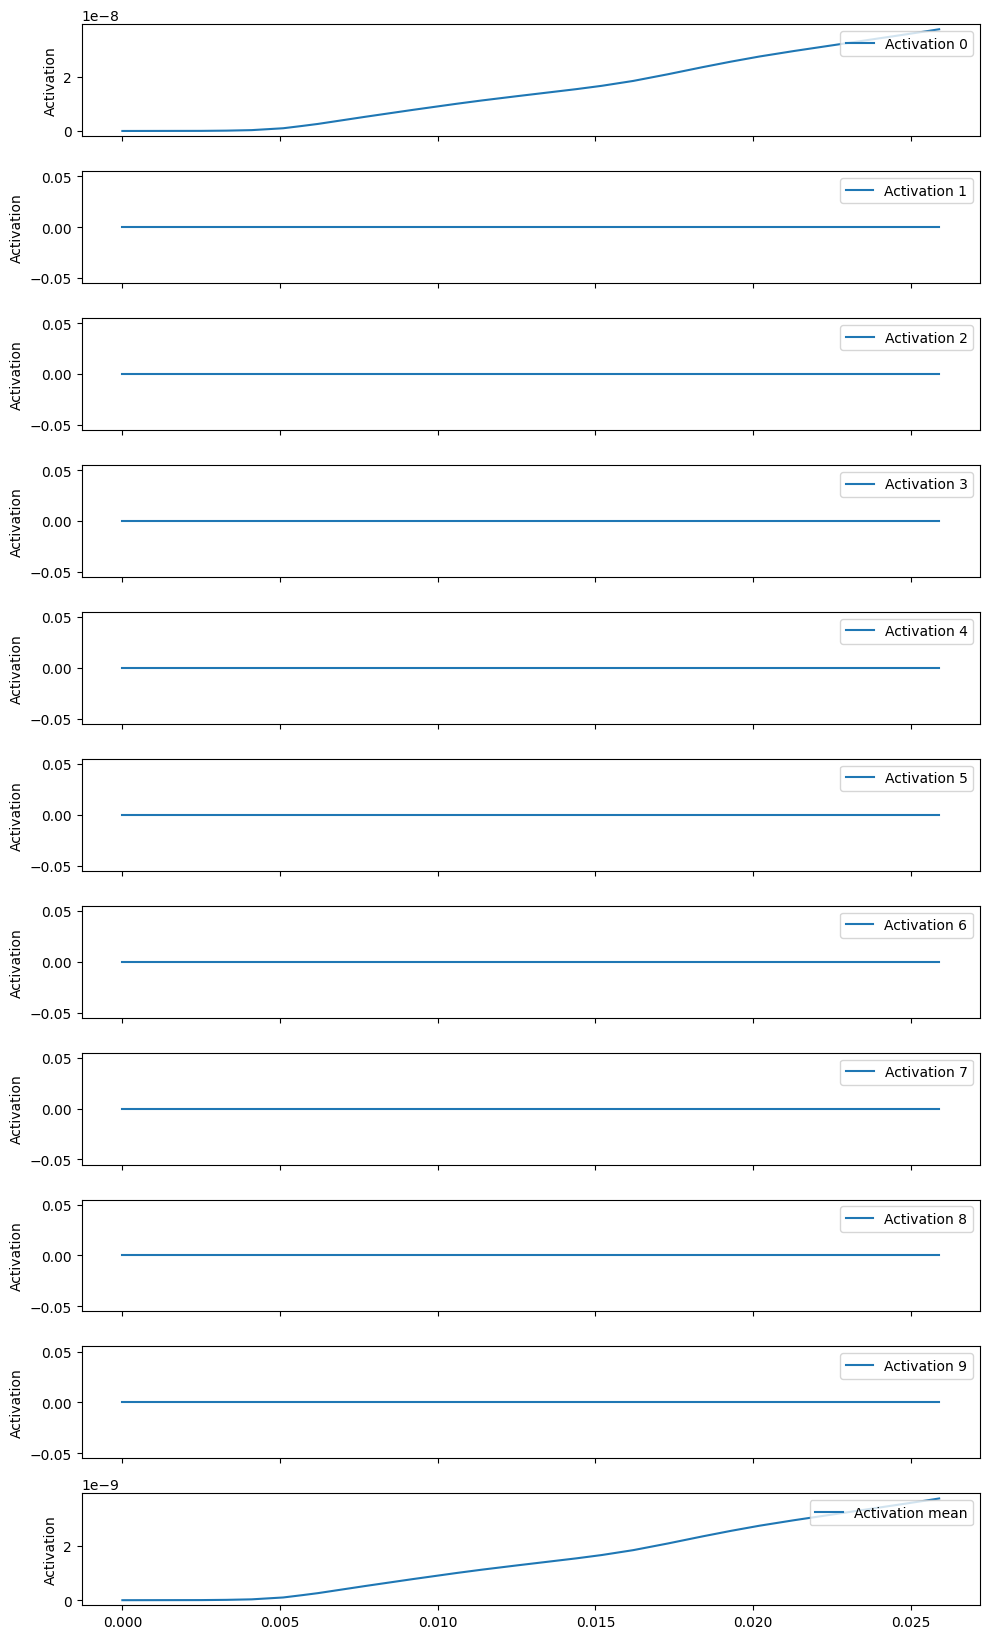

In [24]:
t_stretching_afferent = 16*ms
t_motoneuron_muscle = 10*ms
t_reaction = t_stretching_afferent + t_motoneuron_muscle
n_loop = 1
dt = 0.1*ms

name_temporary_input_opensim = 'activation.npy'
name_temporary_output_opensim = 'muscle_output.sto'
name_output_spikes = 'spikes.json'
name_output_muscle='muscle.df'

neuron_population = {"Ia": 10, "II": 10, "exc": 10, "motor": 10}

# Initialize stretch and velocity arrays
stretch_init = np.zeros(int(t_reaction/dt))
velocity_init = np.zeros(int(t_reaction/dt))
stretch = stretch_init
velocity = velocity_init

data_muscle = []
data_spikes={}
for j in range(n_loop):

    spikes_Ia, spikes_II, spikes_motoneuron=run_neural_simulations(stretch, velocity, neuron_population,dt,t_reaction,name_output_brian, w_run=500*uS, p_run=0.4 )
     **{f'spikes_times_II_{i}': spikes_Ia[i] for i in range(neuron_population['II'])},
        **{f'spikes_times_Ia_{i}': spikes_II[i] for i in range(neuron_population['Ia'])},
        **{f'spikes_times_motoneuron_{i}': spikes_motoneuron[i] for i in range(neuron_population['motor'])},

    activations=decode_spikes_to_activation(spikes_motoneuron, dt/second, t_reaction/second)
    mean_activation = np.mean(activations, axis=0)
    np.save(name_temporary_input_opensim, mean_activation)
    !source /usr/local/etc/profile.d/conda.sh && conda activate opensim_env && python muscle_sim.py --dt {dt_second} --T {t_reaction_second} --activation {name_activation}  --output {name_output_opensim}

    table = load_sto_file(name_temporary_output_opensim)[:-1] #don't include the last element

    # Create batch data dictionary
    batch_data_muscle = {
        **{f'activation_{i}': activations[i] for i in range(neuron_population['motor'])},
        'activation_mean': mean_activation,
        'stretch': table['stretch'].values,
        'velocity': table['velocity'].values,
        'fiber_length': table['fiber_length'].values,
        'fiber_velocity': table['fiber_velocity'].values
    }

    data_muscle.append(pd.DataFrame(batch_data_muscle))

# Create DataFrame and apply time shifts
df_muscle = pd.concat(data_muscle)

df_muscle['Time']=df_muscle.index*dt/second
# Save the DataFrame to CSV
df_muscle.to_csv(name_output_muscle, index=False)

# Plot time series
plot_times_series(name_output_spikes, name_output_muscle)